# タイタニック

タイタニック号のデータを決定木によって学習し，誰が生存し，誰が死亡するのか当てる．  
データはKaggleからダウンロードする．  
[https://www.kaggle.com/c/titanic/data](https://www.kaggle.com/c/titanic/data)

「Download All」からall.zipファイルをダウンロードする．  
解凍すると，
- gender_submission.csv 
- test.csv 
- train.csv

の3つのCSVファイルが出てくる．
トレーニングデータとテストデータの特徴量を以下に示す．

|英語|日本語|
|-|-|
|PassengerId|識別ユニークID|
|Survived|生存(1)or落命(0)|
|Pclass|旅客等級|
|Name|名前|
|Sex|性別|
|Age|年齢|
|SibSp|同乗中の兄弟/配偶者の数|
|Parch|同乗中の親/子供の数|
|Ticket|チケット番号|
|Fare|料金|
|Cabin|客室番号|
|Embarked|出発港|

特徴量で，以下の3つは説明が必要なので加えます．  

- Pclass(旅客等級）：値は1,2,3で，1が上級を表している．
- Age(年齢)：乗客の年齢．ただし，少数のデータがあり，これは実年齢ではなく推定年齢を表している．
- Embarked(出発港)：出発港は次の3つ．Cはシェルブール(Cherbourg)，Qはクイーンズタウン(Queenstown)，Sはサウサンプトン(Southampton)を表す．

データ数はトレーニングデータが891，テストデータが418である．  
これらの特徴量で，生存に関係しそうな特徴はPclass(旅客等級），Sex（性別），SibSp(同乗中の兄弟/配偶者の数)，Parch（同乗中の親/子供の数）などだと考えられる．逆に，氏名や客室番号は生存に関係なさそうである．これらを調査する．

Text(0.5, 1.0, 'Gender and Survival Rate')

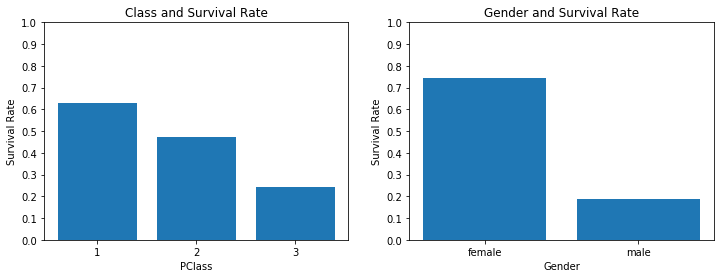

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# データを読み込む
train_set = pd.read_csv('TitanicData/train.csv')
test_set = pd.read_csv('TitanicData/test.csv')

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# PClass （旅客等級）
PClassPlot = train_set['Survived'].groupby(train_set['Pclass']).mean()
ax1.bar(x=PClassPlot.index, height=PClassPlot.values)
ax1.set_ylabel('Survival Rate')
ax1.set_xlabel('PClass')
ax1.set_xticks(PClassPlot.index)
ax1.set_yticks(np.arange(0, 1.1,.1))
ax1.set_title("Class and Survival Rate")

# Sex （性別）
GenderPlot = train_set['Survived'].groupby(train_set['Sex']).mean()
ax2.bar(x=GenderPlot.index, height=GenderPlot.values)
ax2.set_ylabel('Survival Rate')
ax2.set_xlabel('Gender')
ax2.set_xticks(GenderPlot.index)
ax2.set_yticks(np.arange(0, 1.1,.1))
ax2.set_title('Gender and Survival Rate')

これからわかるのは，1等客室の乗客は生存しやすい．女性は生存しやすいということがわかる．

Text(0.5, 1.0, 'Number of Parents and Children abroad and Survival Rate')

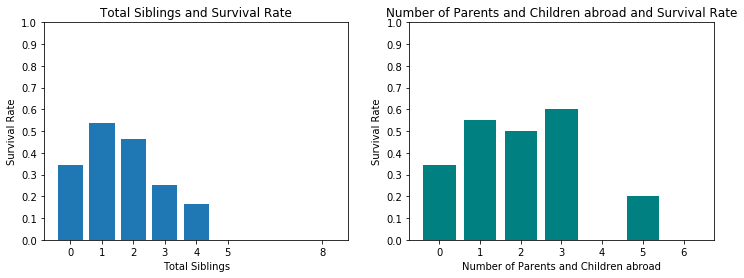

In [4]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# SibSp （同乗中の兄弟/配偶者の数）
SiblingPlot = train_set['Survived'].groupby(train_set['SibSp']).mean()
ax1.bar(x=SiblingPlot.index, height=SiblingPlot.values)
ax1.set_ylabel('Survival Rate')
ax1.set_xlabel('Total Siblings')
ax1.set_xticks(SiblingPlot.index)
ax1.set_yticks(np.arange(0, 1.1,.1))
ax1.set_title('Total Siblings and Survival Rate')

# Parch （同乗中の親/子供の数）
ParchPlot = train_set['Survived'].groupby(train_set['Parch']).mean()
ax2.bar(x=ParchPlot.index, height=ParchPlot.values, width = .8, color='Teal')
ax2.set_ylabel('Survival Rate')
ax2.set_xlabel('Number of Parents and Children abroad')
ax2.set_xticks(ParchPlot.index)
ax2.set_yticks(np.arange(0, 1.1,.1))
ax2.set_title('Number of Parents and Children abroad and Survival Rate')

Siblings(兄弟)が0人よりも，1人以上の方が生存しやすい．また，親兄弟が0人よりも，1人以上の方が生存しやすいことがわかる．

年齢には欠損値があるので，これの処理を行う．

In [5]:
train_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin(客室番号)は欠損が多く，また特徴量には使えそうにないので除外する．  
一方，Age（年齢）とEmbarked（出発港）は，なんらかの欠損値補完を行う必要がある．

Age（年齢）は，中央値で補完することにする．

In [6]:
# 欠損値 Age（年齢）は中央値で補完する
train_set['Age'].fillna(train_set['Age'].median(), inplace=True)

In [7]:
# 欠損値 Embarked（出発港）を補完するために，どの港が多いか調べる
train_set['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
# Sのサウサンプトン(Southampton)が多いのでSで埋める．
train_set['Embarked'].fillna('S', inplace=True)

In [9]:
train_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

これで，Cabin（客室番号）以外の欠損値が補完できた．  

次に，カテゴリデータの処理を行う．  
カテゴリデータとは，Sex（性別）のMale, Femaleのような文字列のことである． 機械学習では，このような文字列は処理が困難なので，数値に変換する．

- Sex（性別） : Male, Female
- Embarked(出発港): S, C, Q
- Pclass(旅客等級）: 1, 2, 3

Sex（性別）は，Maleを1, Femaleを0に変換する．

In [11]:
# 処理前の最初の5行を表示
train_set['Sex'].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [12]:
from sklearn.preprocessing import LabelEncoder

# Sex （性別）の値を処理
labelencoder=LabelEncoder()
train_set['Sex'] = labelencoder.fit_transform(train_set['Sex'])

# 処理後の最初の5行を表示
train_set['Sex'].head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

In [13]:
# Embarkedの確認
train_set['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [14]:
# Embarked （出発港）をダミー変数へ変換
Embarked = pd.get_dummies(train_set['Embarked'], drop_first=True)
Embarked.columns = ['Embarked-Q','Embarked-S']

# Pclass （旅客等級）をダミー変数へ変換
Pclass = pd.get_dummies(train_set['Pclass'], drop_first=True)
Pclass.columns = ['PClass2','PClass3']

# Embarkedの確認
Embarked.head()

,Embarked-Q,Embarked-S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [15]:
train_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,28.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,C


In [16]:
test_set

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## これらの前処理を行った後，決定木とランダムフォレストで学習し，比較する．

In [54]:
import pandas as pd
df = pd.read_csv('TitanicData/train.csv')

from sklearn.model_selection import train_test_split
#欠損値処理
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna('S')

#カテゴリ変数の変換
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

df = df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1)
train_X = df.drop('Survived', axis=1)
train_y = df.Survived
(train_X, test_X ,train_y, test_y) = train_test_split(train_X, train_y, test_size = 0.3, random_state = 666)

### 決定木

In [55]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(train_X, train_y)
pred = clf.predict(test_X)

In [56]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)

pred = clf.predict(test_X)
fpr, tpr, thresholds = roc_curve(test_y, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, test_y)

0.7947761194029851

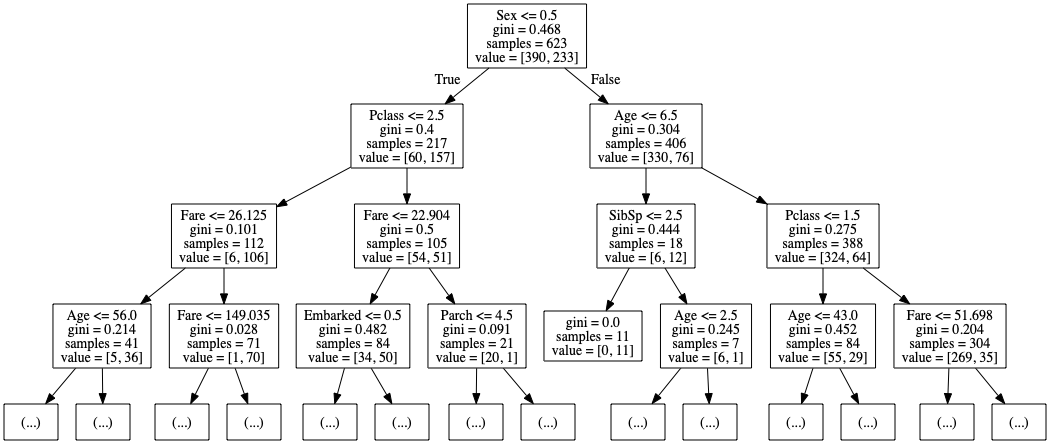

In [57]:
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn.externals.six import StringIO
from sklearn import tree

dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names=train_X.columns, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("graph.pdf")
Image(graph.create_png())

## ランダムフォレスト

In [58]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='entropy',n_estimators=100,random_state=0)
clf = clf.fit(train_X, train_y)
pred = clf.predict(test_X)
fpr, tpr, thresholds = roc_curve(test_y, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, test_y)

0.8283582089552238

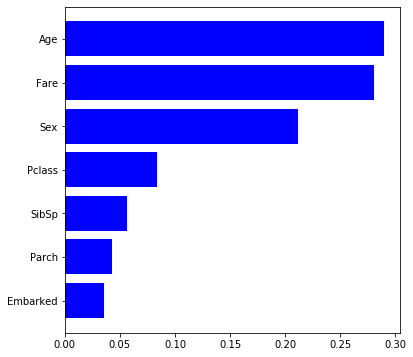

In [59]:
import matplotlib.pyplot as plt

features = train_X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

# kaggleに投稿してみよう

In [73]:
import pandas as pd
df = pd.read_csv('TitanicData/test.csv')

from sklearn.model_selection import train_test_split

#欠損値処理
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna('S')

#カテゴリ変数の変換
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [74]:
PassengerID = df['PassengerId']

In [75]:
df = df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1)

In [76]:
pred = clf.predict(df)

In [82]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [78]:
PassengerID

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [84]:
my_solution = pd.DataFrame({'PassengerId':PassengerID,'Survived':pred})
my_solution = my_solution.set_index('PassengerId')
my_solution.to_csv('submit.csv')